# The Adding Problem:
## Manish 
## CS22MTECH11008

<hr style="border:2px solid gray"> 


# Importing Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

<hr style="border:2px solid gray"> 


# Data generartion

In [2]:
def data_gen(N, seq_len_range=(3, 10), p=0.5, high=1):
    X = []
    Y = []
    for i in range(N):
        seq_len = np.random.randint(seq_len_range[0], seq_len_range[1] + 1)
        X_num = np.random.uniform(low=0, high=high, size=(seq_len, 1))
        X_mask = np.zeros((seq_len, 1))
        positions = np.random.choice(seq_len, size=2, replace=False)
        X_mask[positions] = 1
        X.append(np.append(X_num, X_mask, axis=1))
        Y.append(np.sum(X_num[positions]))
    X = np.array(X, dtype=object)
    Y = np.array(Y).reshape(N, 1)
    return X, Y


In [3]:
X,Y = data_gen(5000)

In [4]:
X = [torch.tensor(x, dtype=torch.float32) for x in X]
Y = torch.tensor(Y, dtype=torch.float32)
loss1=[]
loss2=[]
loss3=[]

<hr style="border:2px solid gray"> 


# RNN-

## \begin{align*}
h_t &= f(W_{hh} h_{t-1} + W_{xh} x_t + b_h) \\
y_t &= W_{hy} h_t + b_y
\end{align*}

where $h_t$ is the hidden state vector at time $t$, $x_t$ is the input vector at time $t$, $y_t$ is the output vector at time $t$, $W_{hh}$ is the weight matrix for the recurrent connections, $W_{xh}$ is the weight matrix for the input connections, $W_{hy}$ is the weight matrix for the output connections, $b_h$ is the bias vector for the hidden state, and $b_y$ is the bias vector for the output.


In [5]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size,output_size=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.wx = nn.Linear(input_size, hidden_size)
        self.wh = nn.Linear(hidden_size, hidden_size)
        self.bias_h = nn.Parameter(torch.zeros(hidden_size))
        self.bias_x = nn.Parameter(torch.zeros(input_size))
        self.wy = nn.Linear(hidden_size, output_size)
        self.y_bias = nn.Parameter(torch.zeros(output_size))
        
    def forward(self, x):
        h = torch.zeros(self.hidden_size)
        for xi in x:
            wx_xi = self.wx(xi) 
            wh_h = self.wh(h) + self.bias_h
            xih = wx_xi + wh_h
            h = torch.tanh(xih)
        y_pred = self.wy(h) + self.y_bias
        
        return y_pred


In [6]:
# define the model, loss function, and optimizer
input_size = X[0].shape[1]
#print(input_size)
hidden_size = 64
model = RNN(input_size, hidden_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# train the model
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for x, y_true in zip(X, Y):
        optimizer.zero_grad()
        #print("x",x)
        #print(x.shape)
        y_pred = model.forward(x)
        #print("y_pred= ",y_pred,"y_actual =",y_true)
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loss1.append(running_loss)
    print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, running_loss/5000))


Epoch [1/10], Loss: 0.0837
Epoch [2/10], Loss: 0.0189
Epoch [3/10], Loss: 0.0099
Epoch [4/10], Loss: 0.0074
Epoch [5/10], Loss: 0.0059
Epoch [6/10], Loss: 0.0050
Epoch [7/10], Loss: 0.0045
Epoch [8/10], Loss: 0.0040
Epoch [9/10], Loss: 0.0036
Epoch [10/10], Loss: 0.0034


<hr style="border:2px solid gray"> 

# LSTM

## \begin{align*}
f_t &= \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) \\
i_t &= \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) \\
\tilde{C}_t &= \tanh(W_C \cdot [h_{t-1}, x_t] + b_C) \\
C_t &= f_t \odot C_{t-1} + i_t \odot \tilde{C}_t \\
o_t &= \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) \\
h_t &= o_t \odot \tanh(C_t)
\end{align*}

where $x_t$ is the input vector at time $t$, $h_{t-1}$ is the hidden state vector at time $t-1$, $f_t$ is the forget gate vector, $i_t$ is the input gate vector, $\tilde{C}_t$ is the candidate cell state vector, $C_t$ is the cell state vector, $o_t$ is the output gate vector, $W_f$, $W_i$, $W_C$, $W_o$ are the weight matrices, $b_f$, $b_i$, $b_C$, $b_o$ are the bias vectors, $\sigma$ is the sigmoid activation

In [7]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size,output_size=1):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # input gate
        self.W_ii = nn.Linear(input_size, hidden_size)
        self.W_hi = nn.Linear(hidden_size, hidden_size)
        self.b_i = nn.Parameter(torch.zeros(hidden_size))
        
        # forget gate
        self.W_if = nn.Linear(input_size, hidden_size)
        self.W_hf = nn.Linear(hidden_size, hidden_size)
        self.b_f = nn.Parameter(torch.zeros(hidden_size))
        
        # output gate
        self.W_io = nn.Linear(input_size, hidden_size)
        self.W_ho = nn.Linear(hidden_size, hidden_size)
        self.b_o = nn.Parameter(torch.zeros(hidden_size))
        
        # cell state
        self.W_ig = nn.Linear(input_size, hidden_size)
        self.W_hg = nn.Linear(hidden_size, hidden_size)
        self.b_g = nn.Parameter(torch.zeros(hidden_size))
        
        #final sate
        self.wy1 = nn.Linear(hidden_size, output_size)
        self.y_bias1 = nn.Parameter(torch.zeros(output_size))
        
    def forward(self, x):
        # x has shape (seq_len, input_size)
        seq_len = x.shape[0]
        #print(seq_len)
        h = torch.zeros(1, self.hidden_size)
        c = torch.zeros(1, self.hidden_size)
        
        for t in range(seq_len):
            i_t = torch.sigmoid(self.W_ii(x[t]) + self.W_hi(h) + self.b_i)
            f_t = torch.sigmoid(self.W_if(x[t]) + self.W_hf(h) + self.b_f)
            
            # output gate
            o_t = torch.sigmoid(self.W_io(x[t]) + self.W_ho(h) + self.b_o)
            
            # cell state
            c_delta = torch.tanh(self.W_ig(x[t]) + self.W_hg(h) + self.b_g)
            
            # update cell state and hidden state
            c = f_t * c + i_t * c_delta
            h = o_t * torch.tanh(c)
        #print(h)
        y_pred = self.wy1(h) + self.y_bias1
        return y_pred


In [8]:
# define the model, loss function, and optimizer
input_size = X[0].shape[1]
#print(input_size)
hidden_size = 64
model2 = LSTM(input_size,hidden_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters())

# train the model
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for x, y_true in zip(X, Y):
        optimizer.zero_grad()
        #print("x",x)
        #print(x.shape)
        y_pred = model2.forward(x)
        #print("y_pred= ",y_pred,"y_actual =",y_true)
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loss2.append(running_loss)
    print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, running_loss/5000))


/home/manish/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10], Loss: 0.0349
Epoch [2/10], Loss: 0.0018
Epoch [3/10], Loss: 0.0012
Epoch [4/10], Loss: 0.0009
Epoch [5/10], Loss: 0.0007
Epoch [6/10], Loss: 0.0005
Epoch [7/10], Loss: 0.0005
Epoch [8/10], Loss: 0.0004
Epoch [9/10], Loss: 0.0004
Epoch [10/10], Loss: 0.0003


<hr style="border:2px solid gray"> 


# GRU

## \begin{align*}
z_t &= \sigma(W_{xz} x_t + W_{hz} h_{t-1} + b_z) \\
r_t &= \sigma(W_{xr} x_t + W_{hr} h_{t-1} + b_r) \\
\tilde{h_t} &= \tanh(W_{xh} x_t + r_t \odot (W_{hh} h_{t-1}) + b_h) \\
h_t &= (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h_t}
\end{align*}

where $h_t$ is the hidden state vector at time $t$, $x_t$ is the input vector at time $t$, $z_t$ is the update gate, $r_t$ is the reset gate, $\tilde{h_t}$ is the candidate hidden state, $\sigma$ is the sigmoid function, $\odot$ represents element-wise multiplication, $W_{xz}$, $W_{xr}$, and $W_{xh}$ are the weight matrices for the input connections, $W_{hz}$, $W_{hr}$, and $W_{hh}$ are the weight matrices for the recurrent connections, $b_z$, $b_r$, and $b_h$ are the bias vectors.


In [9]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # reset gate
        self.W_ir = nn.Linear(input_size, hidden_size)
        self.W_hr = nn.Linear(hidden_size, hidden_size)
        self.b_r = nn.Parameter(torch.zeros(hidden_size))
        
        # update gate
        self.W_iz = nn.Linear(input_size, hidden_size)
        self.W_hz = nn.Linear(hidden_size, hidden_size)
        self.b_z = nn.Parameter(torch.zeros(hidden_size))
        
        # candidate hidden state
        self.W_in = nn.Linear(input_size, hidden_size)
        self.W_hn = nn.Linear(hidden_size, hidden_size)
        self.b_n = nn.Parameter(torch.zeros(hidden_size))
        
        # final state
        self.wy2= nn.Linear(hidden_size, output_size)
        self.y_bias2= nn.Parameter(torch.zeros(output_size))
        
    def forward(self, x):
        # x has shape (seq_len, input_size)
        seq_len = x.shape[0]
        h = torch.zeros(1, self.hidden_size)
        
        for t in range(seq_len):
            r_t = torch.sigmoid(self.W_ir(x[t]) + self.W_hr(h) + self.b_r)
            z_t = torch.sigmoid(self.W_iz(x[t]) + self.W_hz(h) + self.b_z)
            n_t = torch.tanh(self.W_in(x[t]) + self.W_hn(r_t * h) + self.b_n)
            
            # update hidden state
            h = (1 - z_t) * h + z_t * n_t
        
        y_pred = self.wy2(h) + self.y_bias2
        return y_pred

In [10]:
# define the model, loss function, and optimizer
input_size = X[0].shape[1]
#print(input_size)
hidden_size = 64
model3 = GRU(input_size,hidden_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model3.parameters())

# train the model
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for x, y_true in zip(X, Y):
        optimizer.zero_grad()
        #print("x",x)
        #print(x.shape)
        y_pred = model3.forward(x)
        #print("y_pred= ",y_pred,"y_actual =",y_true)
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loss3.append(running_loss)
    print('Epoch [%d/%d], Loss: %.7f' % (epoch+1, num_epochs, running_loss/5000))

Epoch [1/10], Loss: 0.0216526
Epoch [2/10], Loss: 0.0011346
Epoch [3/10], Loss: 0.0007296
Epoch [4/10], Loss: 0.0005288
Epoch [5/10], Loss: 0.0004092
Epoch [6/10], Loss: 0.0003502
Epoch [7/10], Loss: 0.0002979
Epoch [8/10], Loss: 0.0002545
Epoch [9/10], Loss: 0.0002186
Epoch [10/10], Loss: 0.0001910


<hr style="border:2px solid gray"> 


# LOSS VS ITERATIONS

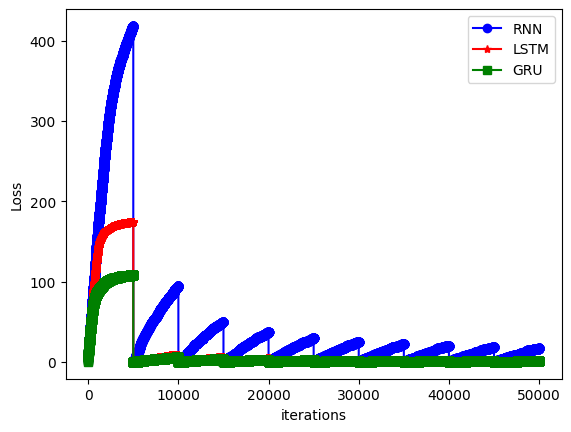

In [11]:
iterations = range(1,len(loss1)+ 1)
# plot all loss lists on the same graph
plt.plot(iterations, loss1, 'bo-', label='RNN')
plt.plot(iterations, loss2, 'r*-', label='LSTM')
plt.plot(iterations, loss3, 'gs-', label='GRU')

# set x and y axis labels and legend
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()

plt.show()


<hr style="border:2px solid gray"> 


# TESTING 

In [12]:
X_test,Y_test = data_gen(200)
X_test = [torch.tensor(x, dtype=torch.float32) for x in X_test]
Y_test = torch.tensor(Y_test, dtype=torch.float32)
acc=[]
x_l=["BASELINE","RNN","LSTM","GRU"]
test_loss=[]

## 1)BASELINE

In [13]:
loss1=0
y_base = torch.ones_like(Y_test)
count = 0
for i in range(Y_test.shape[0]):
    for j in range(Y_test.shape[1]):
        loss1=(Y_test[i][j]- y_base[i][j])
        loss1=loss1**2
        if (abs(Y_test[i][j]- y_base[i][j])<0.01):
            count += 1
acc.append(count/200)
test_loss.append(loss1.item()/200)
print("accuracy = ",count/200)

accuracy =  0.02


## LSTM

In [14]:
count=0
loss2=0;
for x_test, y_test in zip(X_test, Y_test):
        #print("x",x)
        #print(x.shape)
        y_pred = model.forward(x_test)
        loss2=(y_pred-y_test)
        loss2=loss2**2
        if(abs(y_pred-y_test)<0.01):
            count=count+1
acc.append(count/200) 
test_loss.append(loss2.item()/200)
print("accuracy = ",count/200)

accuracy =  0.2


## RNN

In [15]:
count=0
loss3=0
for x_test, y_test in zip(X_test, Y_test):
        #print("x",x)
        #print(x.shape)
        y_pred = model2.forward(x_test)
        loss3=(y_pred-y_test)
        loss3=loss3**2
        if(abs(y_pred-y_test)<0.01):
            count=count+1
acc.append(count/200)
test_loss.append(loss3.item()/200)
print("accuracy = ",count/200)            

accuracy =  0.39


## GRU

In [16]:
count=0
loss4=0
for x_test, y_test in zip(X_test, Y_test):
        #print("x",x)
        #print(x.shape)
        y_pred = model3.forward(x_test)
        loss4=(y_pred-y_test)
        loss4=loss4**2
        if(abs(y_pred-y_test)<0.01):
            count=count+1
acc.append(count/200)   
test_loss.append(loss4.item()/200)
print("accuracy = ",count/200)           

accuracy =  0.91


<hr style="border:2px solid gray"> 


## GRAPHS

GRAPH 1) -accuracy vs models 
      2)-loss vs models

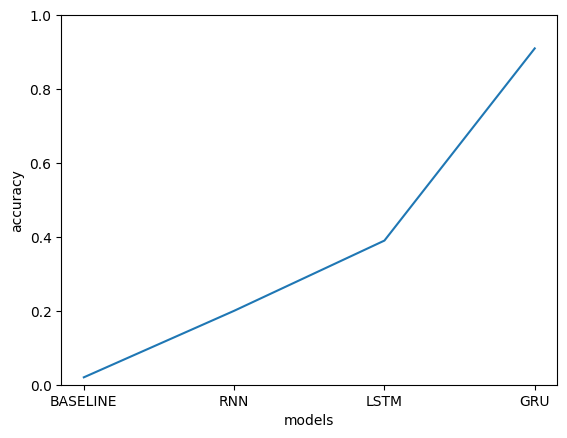

In [17]:
plt.plot(x_l,acc)
plt.xlabel('models')
plt.ylabel('accuracy')
plt.xticks(range(len(x_l)), x_l)
#plt.yticks(range(len(acc)), acc)
plt.ylim(0, 1)
plt.show()

In [18]:
test_loss

[0.00040167596191167834,
 1.013088272884488e-05,
 3.546317748259753e-07,
 8.04704995971406e-09]

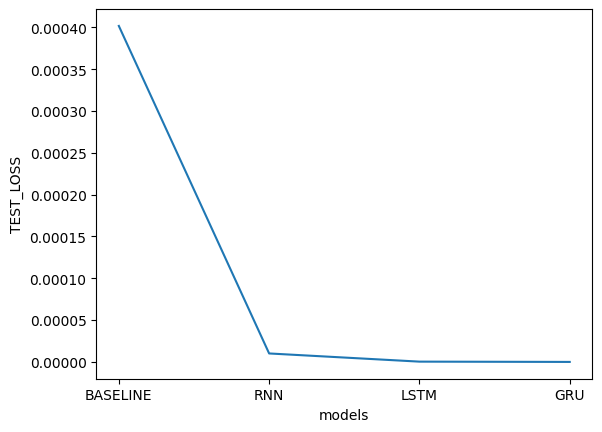

In [19]:
plt.plot(x_l,test_loss)
plt.xlabel('models')
plt.ylabel('TEST_LOSS')
plt.xticks(range(len(x_l)), x_l)
#plt.yticks(range(len(acc)), acc)
#plt.ylim(0, 1)
plt.show()

<hr style="border:2px solid gray"> 
